In [ ]:
from requests import get
import re

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px

import nltk

from nltk.corpus import stopwords
from nltk import SnowballStemmer, LancasterStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


import string

In [ ]:
lyrics_df = pd.read_csv('genius_lyrics.csv')
lyrics_df.head()

## Processing Text Data

**Text analysis** is used to extract useful information from or summarize a large amount of unstructured text stored in documents. This opens up the opportunity of using text data alongside more conventional data sources (e.g. surveys and administrative data). The goal of text analysis is to take a large corpus of complex and unstructured text data and extract important and meaningful messages in a comprehensible way. 

Text analysis can help with a wide variety of tasks including:

* **Information Retrieval**: Find relevant information in a large database, such as a systematic literature review, that would be very time-consuming for humans to do manually. 

* **Clustering and Text Categorization**: Summarize a large corpus of text by finding the most important phrases, using methods like topic modeling. 

* **Text Summarization**: Create category-sensitive text summaries of a large corpus of text. 

* **Machine Translation**: Translate documents from one languagem to another. 
 
## Glossary of Terms

* **Corpus**: A corpus is the set of all text documents used in your analysis; for example, your corpus of text may include hundreds of abstracts from patent data.

* **Tokenize**: Tokenization is the process by which text is separated into meaningful terms or phrases. In English this is easy to do for individual words, as they are separated by whitespace; however, it can get more complicated to  automate determining which groups of words constitute meaningful phrases. 

* **Stemming**: Stemming is normalizing text by reducing all forms or conjugations of a word to the word's most basic form. In English, this can mean making a rule of removing the suffixes "ed" or "ing" from the end of all words, but it gets more complex. For example, "to go" is irregular, so you need to tell the algorithm that "went" and "goes" stem from a common lemma, and should be considered alternate forms of the word "go."

* **Stop Words**: Stop words are words that have little semantic meaning but occur very frequently, like prepositions, articles and common nouns. For example, every document (in English) will probably contain the words "and" and "the" many times. You will often remove them as part of preprocessing using a list of stop words.


# Preparing the data

First, we will lowercase every word in the abstract column so that we don't run into issues with matching words that aren't capitalized in the same way. 

In [ ]:
lyrics_df['lyrics_processed'] =  lyrics_df.lyrics.str.lower()
lyrics_df.head()

## Removing Punctuation and Tokenizing

For some purposes, we might want to preserve punctuation. For example, if we wanted to be able to detect sentiment of text, we might want to keep exclamation points, because they signify something about the text. For our purposes, however, we will simply strip the punctuation so that it does not affect our analysis. 

We also want to separate text into individual tokens (generally individual words). To do this all of this, we'll use `RegexpTokenizer` to break apart individual words and identify tokens according to a regular expression. Here, we use the regular expression `\w+`, which catches all "words" which contain letters or numbers. Anything that is not a number, such as punctuation or spaces, will not be included and be considered a separator between tokens.

In [ ]:
tokenizer = RegexpTokenizer(r'\w+')
tokenizer

Here's an example of tokenizing the lyrics for the first song and printing the first 50 words. Notice that contractions ("I'm") are split into separate terms here

In [ ]:
print(tokenizer.tokenize(lyrics_df.lyrics_processed[0])[:50])

<font color ='red'>**Question 1: Apply the tokenizer to each  in `lyrics_df`. You should get a pandas Series of lists, with each list representing the tokenized abstract. Call this Series `bag_of_words`.**</font>


In [ ]:
###


###

Now we'll put the processed texts in a data frame and use "explode" to unnest each series. 

In [ ]:
lyrics_and_data = pd.DataFrame({'lyrics_processed': bag_of_words, 
                               'genre': lyrics_df.genre,
                               'artist' : lyrics_df.artists,
                               'title' : lyrics_df.titles,
                               'url' : lyrics_df.url
                              }).explode('lyrics_processed')

lyrics_and_data.head()

### Visualizing the Data

Let's take a look at our data to see what types of words are most common. This is a common intermediate step that is used to simply get a sense for what is in our dataset. Remember, we are converting blocks of text into individual words to try to get a sense for what these songs are about. (you might notice that our results here are not especially informative)

In [ ]:
top_ten_words = lyrics_and_data.lyrics_processed.value_counts().head(15)
px.bar(top_ten_words[::-1], orientation = 'h',
       labels = {'lyrics_processed':"lyrics",
                 'value': 'count'
               }
      )

## Removing meaningless text - Stopwords

Stopwords are words that are found commonly throughout a text and carry little semantic meaning. Examples of common stopwords are prepositions ("to", "on", "in"), articles ("the", "an", "a"), conjunctions ("and", "or", "but") and common nouns. For example, the words *the* and *of* are totally ubiquitous, so they won't serve as meaningful features, whether to distinguish documents from each other or to tell what a given document is about. You may also run into words that you want to remove based on where you obtained your corpus of text or what it's about. There are many lists of common stopwords available for you to use, both for general documents and for specific contexts, so you don't have to start from scratch.   

We can eliminate stopwords by checking all the words in our corpus against a list of commonly occuring stopwords that comes with NLTK.

In [ ]:
nltk.download('stopwords')

In [ ]:
stop = stopwords.words('english')
stop[0:10]

In [ ]:
lyrics_and_data['stopword'] = lyrics_and_data.lyrics_processed.isin(stop)

In [ ]:
# viewing the result
lyrics_and_data.head()


<font color ='red'>**Question 2: Make a plotly bar chart showing the top 15 terms excluding stopwords**</font>

We'll go ahead and filter out the stopwords entirely for the next part of the analysis.

In [219]:
lyrics_filtered = lyrics_and_data[lyrics_and_data.stopword==False].drop(columns='stopword')

## Stemming or Lemmatization - Distilling text data

We'll usually try to simplify our bag-of-words analysis by grouping together different inflections of the same terms. Word-endings that indicate things like pluralization and tense are useful in the context of human communication, but they're not informative when we're trying to do things like identify the topic or tone of a text.

There are two common approaches to this kind of normalization: 

- **Lemmatization** uses parts-of-speech and context clues to convert words to their basic dictionary form. 
- **Stemming** uses some simple hueristics to remove word inflections. 

Stemming is more error-prone than lemmatization, and sometimes results in words that you won't find in a dictionary, but it has the advantage of being much faster because it relies in simple rules whereas lemmatization considers word context and parts-of-speech. 

There are multiple stemming algorithms with different rule sets and differing strengths and weaknesses. In this notebook, we'll use the Snowball Stemmer. You'll notice this works pretty well for many words, but gives odd results for others:

In [ ]:
# load the stemming algorthim
stemmer = SnowballStemmer("english")

In [235]:
# apply it to some terms
forms = ['lying', 'fisherman', 'change', 'systematic', 'stapled', 'catlike', 'argument', 'alphabetical']
print([stemmer.stem(i) for i in forms])


['lie', 'fisherman', 'chang', 'systemat', 'stapl', 'catlik', 'argument', 'alphabet']


In [236]:
#applying the snowball stemmer to the lyrics data
lyrics_filtered['lyrics_stemmed'] = lyrics_filtered.lyrics_processed.apply(stemmer.stem)
lyrics_filtered.head(n=15)

,lyrics_processed,genre,artist,title,url,lyrics_stemmed
0,look,rap,Eminem,Rap God,https://genius.com/Eminem-rap-god-lyrics,look
0,gonna,rap,Eminem,Rap God,https://genius.com/Eminem-rap-god-lyrics,gonna
0,go,rap,Eminem,Rap God,https://genius.com/Eminem-rap-god-lyrics,go
0,easy,rap,Eminem,Rap God,https://genius.com/Eminem-rap-god-lyrics,easi
0,hurt,rap,Eminem,Rap God,https://genius.com/Eminem-rap-god-lyrics,hurt
0,feelings,rap,Eminem,Rap God,https://genius.com/Eminem-rap-god-lyrics,feel
0,going,rap,Eminem,Rap God,https://genius.com/Eminem-rap-god-lyrics,go
0,get,rap,Eminem,Rap God,https://genius.com/Eminem-rap-god-lyrics,get
0,one,rap,Eminem,Rap God,https://genius.com/Eminem-rap-god-lyrics,one
0,chance,rap,Eminem,Rap God,https://genius.com/Eminem-rap-god-lyrics,chanc


<font color ='red'>**Question 3: Try stemming using an alternative stemmer: the Lancaster stemmer. How does it differ from the Snowball Stemmer?**</font>


In [237]:
lancaster = LancasterStemmer()

print([lancaster.stem(i) for i in forms])



['lying', 'fisherm', 'chang', 'system', 'stapl', 'catlik', 'argu', 'alphabet']


# Terms by genre


Now, we'll try calculating the top words separately for each genre. 

In [243]:
top_words =lyrics_filtered.value_counts('lyrics_stemmed').head(10)
terms_by_genre = pd.crosstab(lyrics_filtered.lyrics_stemmed, lyrics_filtered.genre, normalize='columns')



Let's keep only the most frequent words so that we don't have too many to look at at once.

In [239]:
top_words_by_genre = terms_by_genre.loc[top_words.index[::-1],:]
top_words_by_genre

genre,country,pop,rap,rb,rock
lyrics_stemmed,,,,,
one,0.007419,0.007995,0.006765,0.007790,0.006216
go,0.007029,0.009945,0.006840,0.007946,0.010686
ooh,0.014447,0.008424,0.005542,0.006850,0.012050
get,0.007809,0.010101,0.011708,0.008808,0.009105
got,0.005857,0.010725,0.012407,0.010921,0.006761
love,0.010022,0.016029,0.006416,0.014523,0.010523
know,0.014578,0.015873,0.012457,0.017420,0.011177
yeah,0.005792,0.018330,0.017575,0.019807,0.013522
like,0.014057,0.016848,0.016427,0.018202,0.013413


In [240]:
# could also do top terms separately for each genre with this slightly messy code: 
#terms_by_genre_long = terms_by_genre.melt(ignore_index=False).sort_values(by='value', ascending=False).groupby('genre').head(n=5)
#terms_by_genre_long

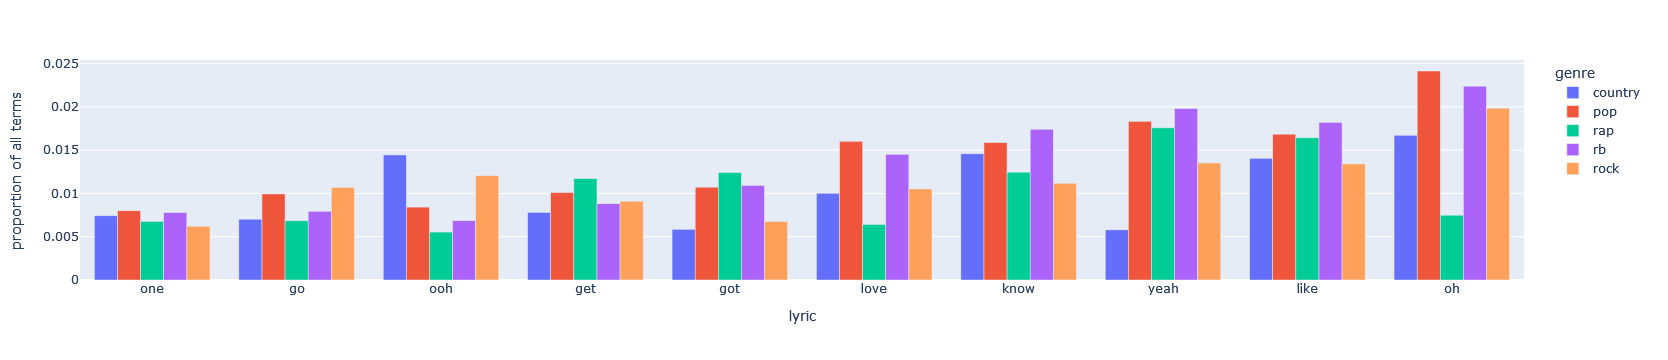

In [241]:
fig = px.bar(top_words_by_genre, 
             y = top_words_by_genre.columns, 
             x = top_words_by_genre.index, 
             barmode='group',
       orientation = 'v', 
            labels = {'lyrics_stemmed': 'lyric',
                      'value': 'proportion of all terms'
                     }
            )

fig.show()

<font color ='red'>**Question 4: The code below generates a table with the number of unique stemmed terms per song. Make a plot showing the distribution of the variable across each genre**</font>


In [255]:
lyrics_counts = lyrics_filtered.groupby(['title', 'genre', 'artist'])['lyrics_stemmed'].nunique().reset_index()


,title,genre,artist,lyrics_stemmed
0,1-800-273-8255,pop,Logic,93
1,1-800-273-8255,rap,Logic,93
2,1-800-273-8255,rb,Logic,93
3,"10,000 Hours",country,Dan + Shay & Justin Bieber,49
4,34+35,rb,Ariana Grande,107
...,...,...,...,...
495,​thanK you aIMee,country,Taylor Swift,112
496,​when the party’s over,pop,Billie Eilish,35
497,​when the party’s over,rb,Billie Eilish,35
498,’Till I Collapse,rap,Eminem,228


# Extra stuff

## Finding Key terms

What terms are disproportionately likely to occur in a country music compared to other genres? There are a number of metrics used to calculate this stat, called "keyness". The code below uses the log base 2 ratio of proportions between two corpuses. Positive numbers indicate that a term is more associated with the "target" group, and negative numbers indicate that they're more strongly associated with the "negative" group.



In [ ]:
import math
target = lyrics_filtered.loc[lyrics_filtered['genre'] == 'country'].value_counts('lyrics_stemmed')
baseline = lyrics_filtered.loc[lyrics_filtered['genre'] !='country'].value_counts('lyrics_stemmed')

keyness = []
target_total = sum(target)
baseline_total = sum(baseline)
norm = 1/ (baseline_total + target_total)
combined =  target.index.union(baseline.index)
# placing a minimum threshold on the total number of word occurrences
minimum = 10

for i in combined:
    # adds a small value for terms that don't occur at all
    target_count = target[i] if i in target.index else norm
    baseline_count = baseline[i] if i in baseline.index else norm
    if (baseline_count + target_count) < minimum: 
        continue
    target_prop = ((target_count/target_total)) 
    baseline_prop = ((baseline_count/baseline_total)) 
    stats = {'term': i,
             'count_target' : int(target_count),
             'count_baseline': int(baseline_count),
             'oddsratio': math.log2( target_prop/baseline_prop)}
    keyness.append(stats)
        

# put the results in a data frame and sort them
df=pd.DataFrame(keyness).sort_values('oddsratio', ascending=False)


In [ ]:
df.head(15)

In [ ]:
# Wrapping it in a function definition

def keyness(target, baseline, minimum=10):
    """
    Given two sets of value counts, calculate keyness using the log 2 ratio of
    term proportions. 
    """
    keyness = []
    target_total = sum(target)
    baseline_total = sum(baseline)
    norm = 1/ (baseline_total + target_total)
    combined =  target.index.union(baseline.index)
    for i in combined:
        # adds a small value if the term doesn't occur anywhere in the corpus
        target_count = target[i] if i in target.index else norm
        baseline_count = baseline[i] if i in baseline.index else norm
        if (baseline_count + target_count) < minimum: 
            continue
        target_prop = (target_count/target_total)
        baseline_prop = (baseline_count/baseline_total)
        stats = {'term': i,
                 'count_target' : int(target_count),
                 'count_baseline': int(baseline_count),
                 'oddsratio': math.log2( target_prop/baseline_prop)}
        keyness.append(stats)
        

        # put the results in a data frame and sort them
    keydata=pd.DataFrame(keyness).sort_values('oddsratio', ascending=False)
    return(keydata)




In [ ]:
# what terms are most strongly associated with Drake? 

df=keyness(lyrics_filtered.loc[lyrics_filtered['artist'] == 'Drake'].value_counts('lyrics_stemmed'), 
           lyrics_filtered.loc[lyrics_filtered['artist']!='Drake'].value_counts('lyrics_stemmed'),
           minimum= 5)

df.head(15)

# Example of lemmatization

This may be overkill for what we're doing here, but here's an example of using lemmatization instead of stemming for the song Old Town Road. You'll notice that the lemmatization is able to do things like convert "to be" verbs to their base form and separate contractions like "can't" into separate words.


In [ ]:
text = lyrics_df.loc[lyrics_df['titles'] == "Old Town Road", 'lyrics'].item()
stemmer = SnowballStemmer("english")

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')
 
# Process the text using spaCy
doc = nlp(text)

# originals
lowercase_tokens = [token.lower_ for token in doc]

# stemmed
stemmed_tokens = [stemmer.stem(token.lower_) for token in doc]

# lemmatized
lemmatized_tokens = [token.lemma_ for token in doc]


In [ ]:

# putting it all in a data frame for comparison: 

pd.DataFrame({"original": lowercase_tokens, 
             "stemmed": stemmed_tokens,
              "lemma": lemmatized_tokens
             }).head(n = 25)

